By [Kevin Michalewicz](https://kevinmichalewicz.com) on Jan 2025

This notebook discusses interpretability in the context of LLM-GCN.

In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from gcn_bf.utils.biology_utils import bootstrap_test, count_consecutive_secondary, is_in_cdr, get_epitope_members, get_paratope_members, get_antigen_only, get_variable_region_only, preprocess_interpretability
from gcn_bf.utils.torch_utils import load_pickle
from gcn_bf.utils.plot_utils import boxplot_delta_e, plot_consecutive_secondary, plot_prediction_errors

/Users/kevinmicha/anaconda3/envs/gcn-bagpype/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre-processing

In [2]:
# Getting test set indices
data_path = '../data/'
interpretability_path = 'interpretability_files/'
test_indices = np.load(data_path+'test_indices.npy')
pdb_codes = np.load(data_path+'pdb_codes.npy')
test_set = pdb_codes[test_indices]

# Obtaining corresponding sequences, secondary structure, diversity scores, chain lengths, and members of paratope and epitope
sequences = torch.load(data_path+'sequences.pt', 'rb')
sequences = [sequences[i] for i in test_indices]
residue_ids = list(np.load(interpretability_path+'residue_ids_v.npy'))

secondary = load_pickle(interpretability_path+'secondary_full.pkl')
ds = load_pickle(interpretability_path+'conservation_scores.pkl')

heavy = [len(seq.split(':')[0]) for seq in sequences]
light = [len(seq.split(':')[1]) for seq in sequences]

paratope_epitope = torch.load(interpretability_path+'paratope_epitope.pt', 'rb')
paratope_epitope = [paratope_epitope.get(pdb, []) for pdb in test_set]
number_bootstraps = 1000000 # Can be adapted if a differen ASL is required

# Finally, we load the MSEs for sequence alone and when adding the graph path
mse = np.load(interpretability_path+'mse_v.npy')
mse_seq = np.load(interpretability_path+'mse_seq_v.npy')
errors = load_pickle(interpretability_path+'errors_with_antigen.pkl')
errors_seq = load_pickle(interpretability_path+'errors_with_antigen_seq.pkl')
delta_e, secondary_v, ds, heavy_v, light_v, epitope_m, paratope_m = preprocess_interpretability(errors, errors_seq, secondary, ds, heavy, light, paratope_epitope)

# For some cases we only need the antibody variable region or antigen only
delta_e_v = get_variable_region_only(delta_e, heavy, light, heavy_v, light_v)
errors_v = get_variable_region_only(errors, heavy, light, heavy_v, light_v)
errors_seq_v = get_variable_region_only(errors_seq, heavy, light, heavy_v, light_v)
delta_e_ag = get_antigen_only(delta_e, heavy, light)
secondary_ag = get_antigen_only(secondary, heavy, light)

## Prediction errors for each antibody position

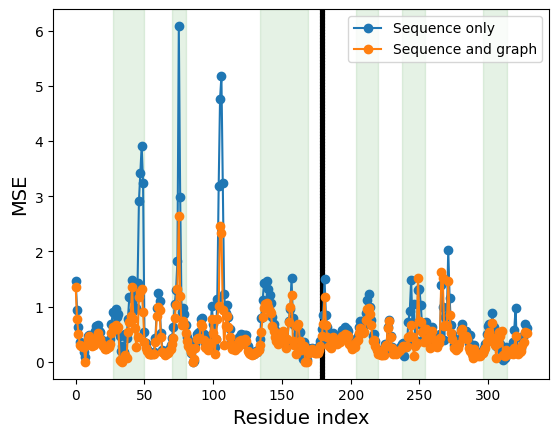

In [3]:
plot_prediction_errors(mse, mse_seq, residue_ids)

## $\Delta e$ against different variables

#### CDR vs Framework

<Figure size 640x480 with 0 Axes>

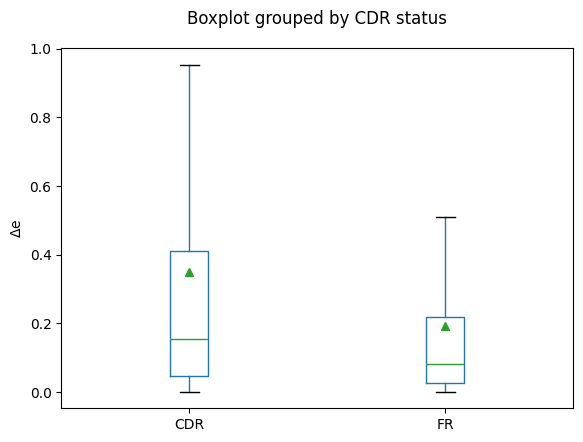

In [4]:
boxplot_delta_e(delta_e_v, secondary_v, ind_class='cdr_status')

In [5]:
bootstrap_test(delta_e_v, secondary_v, ind_class='cdr_status', B=number_bootstraps)

Difference of means between CDR and FR: 0.15684199333190918 (p-value < 1e-06).


#### Antibody secondary structure

<Figure size 640x480 with 0 Axes>

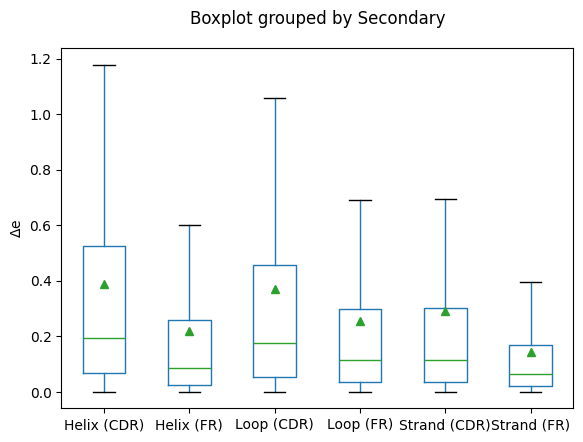

In [6]:
boxplot_delta_e(delta_e_v, secondary_v)

In [7]:
bootstrap_test(delta_e_v, secondary_v, B=number_bootstraps)

Difference of means between Helix (CDR) and Loop (CDR): 0.017916083335876465 (p-value = 0.184597).
Difference of means between Loop (CDR) and Strand (CDR): 0.08000147342681885 (p-value < 1e-06).
Difference of means between Strand (CDR) and Loop (FR): 0.03797665238380432 (p-value = 0.002548).
Difference of means between Loop (FR) and Helix (FR): 0.03437505662441254 (p-value = 0.005819).
Difference of means between Helix (FR) and Strand (FR): 0.07487232983112335 (p-value = 1e-06).


#### Antigen secondary structure

<Figure size 640x480 with 0 Axes>

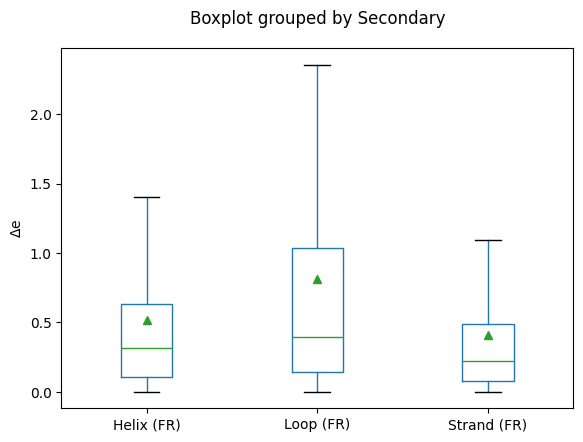

In [8]:
boxplot_delta_e(delta_e_ag, secondary_ag)

In [9]:
bootstrap_test(delta_e_ag, secondary_ag, ind_class='secondary_ag', B=number_bootstraps)

Difference of means between Loop and Helix: 0.2940468192100525 (p-value < 1e-06).
Difference of means between Helix and Strand: 0.10808223485946655 (p-value = 0.019145).


#### Diversity scores

0-1    8609
1-2    6922
>2     1855
Name: count, dtype: int64


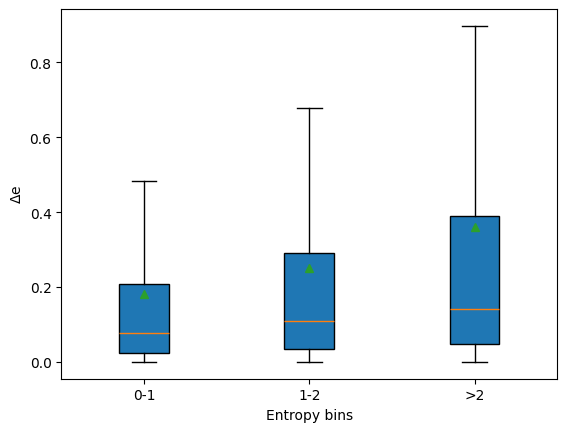

In [10]:
boxplot_delta_e(delta_e_v, ds, ind_class='entropy')

In [11]:
bootstrap_test(delta_e_v, ds, ind_class='entropy', B=number_bootstraps)

Difference of means between >2 and 1-2: 0.11104026436805725 (p-value < 1e-06).
Difference of means between 1-2 and 0-1: 0.06841161847114563 (p-value < 1e-06).


#### Epitope membership

<Figure size 640x480 with 0 Axes>

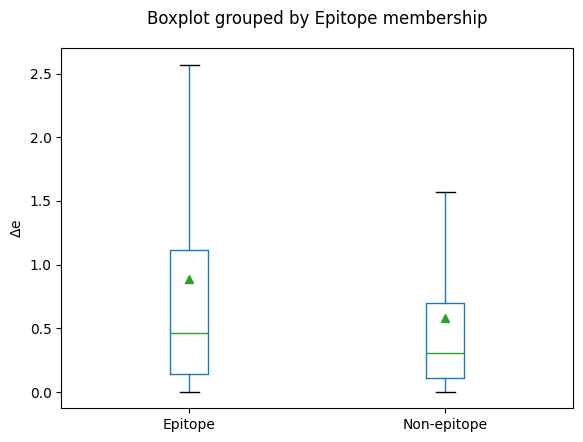

In [12]:
boxplot_delta_e(delta_e_ag, epitope_m, ind_class='epitope')

In [13]:
bootstrap_test(delta_e_ag, epitope_m, ind_class='epitope', B=number_bootstraps)

Difference of means between Epitope and Non-epitope: 0.30584824085235596 (p-value < 1e-06).


#### Paratope membership

<Figure size 640x480 with 0 Axes>

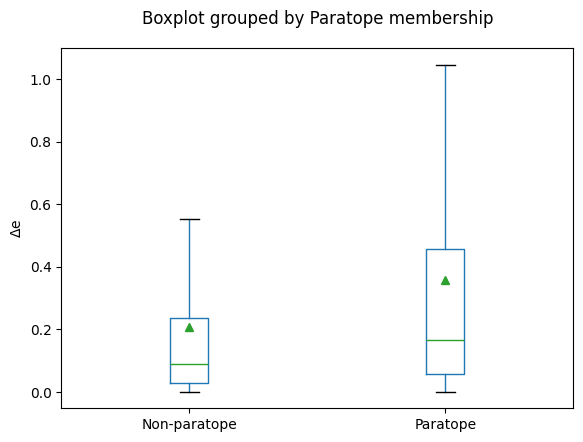

In [14]:
boxplot_delta_e(delta_e_v, paratope_m, ind_class='paratope')

In [15]:
bootstrap_test(delta_e_v, paratope_m, ind_class='paratope', B=number_bootstraps)

Difference of means between Paratope and Non-paratope: 0.14819853007793427 (p-value < 1e-06).


## Consecutive secondary structure motifs

50 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 50 consecutive helix - FR: 0, CDR: 0, Total: 0
49 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 49 consecutive helix - FR: 0, CDR: 0, Total: 0
48 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 48 consecutive helix - FR: 0, CDR: 0, Total: 0
47 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 47 consecutive helix - FR: 0, CDR: 0, Total: 0
46 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 46 consecutive helix - FR: 0, CDR: 0, Total: 0
45 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 45 consecutive helix - FR: 0, CDR: 0, Total: 0
44 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 44 consecutive helix - FR: 0, CDR: 0, Total: 0
43 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 43 consecutive helix - FR: 0, CDR: 0, Total: 0
42 consecutive helix - FR: 0, CDR: 0, Total: 0
Average delta_e for 42 consecutive helix 

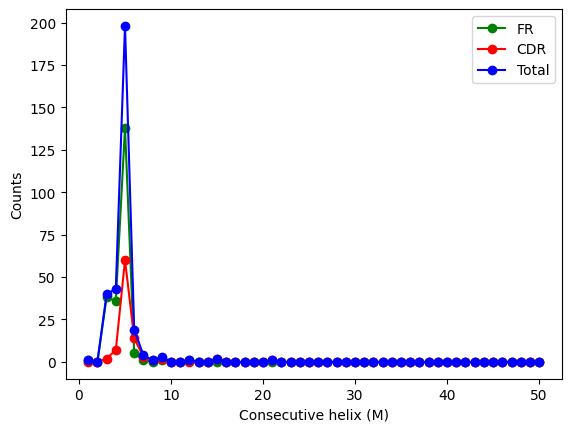

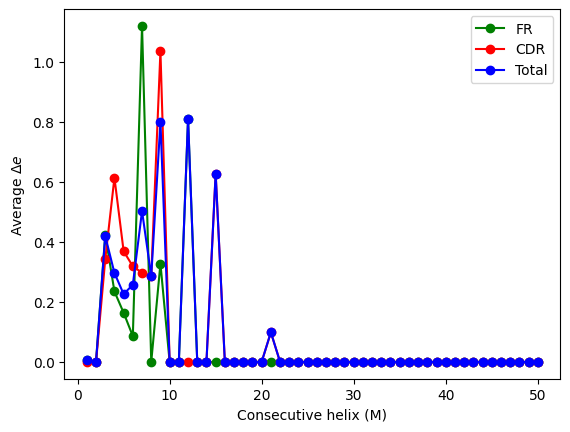

In [16]:
plot_consecutive_secondary(delta_e_v, secondary_v, max_M=50, secondary_type='helix')